In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as text  # this module is a must if using tfhub's resources
#import tensorflow_models as tfm
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import metrics as met
from official.nlp import optimization  # to create AdamW optimizer
import graphviz
import pydot
#import shutil
#import os
import json
import GPUtil
import time

C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Severus\AppData\Roaming\Python\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [3]:
from sources.Dataset import load_dataset
from sources.Models import ModelBuilder

In [4]:
class CONFIG: 
    EPS = 1e-8 
    EPOCHS = 8 # 3~5
    BATCH_SIZE = 16 # 8, 32
    LEARNING_RATE = 3e-5 # 1e-5
    MAX_LENGTH = 128 # 256
    ENCODER_TYPE = 'roberta-base' # large, RoBERTa, DeBERTa
    EXTRA_LAYERS = 'None'
    OPTIMIZER ='adamw'
    PREPROCESS_METHOD='Marking'   
    DEVICE_TYPE = "cuda" # Cuda or alternative
    SAVE_MODEL=True
    TASK='RE-classification'
config=CONFIG()

In [5]:
data_path={'train':'semeval_train.txt',
           'test':'semeval_test.txt',
           'valid':'semeval_val.txt'}

In [6]:
train_ds,test_ds,valid_ds,classdict=load_dataset(data_path,config.PREPROCESS_METHOD)
train_ds['data']=train_ds['data'].shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds['data']=valid_ds['data'].shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds['data']=test_ds['data'].batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:

def evaluation(y_true,y_pred):
    acc=met.accuracy_score(y_true,y_pred)
    p=met.precision_score(y_true,y_pred,average=None,zero_division=True).tolist()
    r=met.recall_score(y_true,y_pred,average=None).tolist()
    f1=met.f1_score(y_true,y_pred,average=None).tolist()
    weighted_p=met.precision_score(y_true,y_pred,average='weighted',zero_division=True)
    weighted_r=met.recall_score(y_true,y_pred,average='weighted')
    weighted_f1=met.f1_score(y_true,y_pred,average='weighted')
    macro_p=met.precision_score(y_true,y_pred,average='macro',zero_division=True)
    macro_r=met.recall_score(y_true,y_pred,average='macro')
    macro_f1=met.f1_score(y_true,y_pred,average='macro')
    micro_p=met.precision_score(y_true,y_pred,average='micro',zero_division=True)
    micro_r=met.recall_score(y_true,y_pred,average='micro')
    micro_f1=met.f1_score(y_true,y_pred,average='micro')
    cmatrix=met.confusion_matrix(y_true,y_pred).tolist()
    return {'accuracy':acc,'confusion_matrix':cmatrix,
            'Categorical':{'precision':p,'recall':r,'f1':f1},'Weighted':{'precision':weighted_p,'recall':weighted_r,'f1':weighted_f1},
            'Macro':{'precision':macro_p,'recall':macro_r,'f1':macro_f1},'Micro':{'precision':micro_p,'recall':micro_r,'f1':micro_f1},}

In [8]:
print(classdict)
print(len(classdict))
invdict=np.zeros(len(classdict)).tolist()
for k,v in classdict.items():
    invdict[v]=k

{'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Entity-Destination(e1,e2)': 5, 'Content-Container(e1,e2)': 6, 'Message-Topic(e1,e2)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
19


In [9]:
tf.keras.backend.clear_session()

In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.CategoricalAccuracy()]

In [11]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds['data']).numpy()
num_train_steps = steps_per_epoch * config.EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=CONFIG.LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

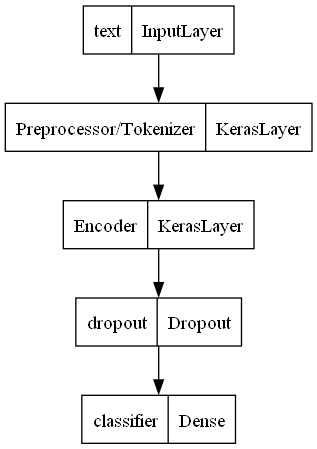

In [12]:
model = ModelBuilder().build_classifier_model(len(classdict),config.ENCODER_TYPE,config.EXTRA_LAYERS)
tf.keras.utils.plot_model(model,'results/img/model.png')
#print(model.summary())

In [13]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
trs_time=time.process_time()
history=model.fit(train_ds['data'],validation_data=valid_ds['data'],verbose=1,epochs=CONFIG.EPOCHS)
tre_time=time.process_time()
train_time=tre_time-trs_time

Epoch 1/8
407/407 [==============================] - 241s 568ms/step - loss: 1.9200 - categorical_accuracy: 0.4152 - val_loss: 0.8046 - val_categorical_accuracy: 0.7502
Epoch 2/8
407/407 [==============================] - 228s 561ms/step - loss: 0.6821 - categorical_accuracy: 0.7935 - val_loss: 0.6546 - val_categorical_accuracy: 0.7930
Epoch 3/8
407/407 [==============================] - 229s 563ms/step - loss: 0.3968 - categorical_accuracy: 0.8797 - val_loss: 0.6334 - val_categorical_accuracy: 0.8238
Epoch 4/8
407/407 [==============================] - 231s 568ms/step - loss: 0.2346 - categorical_accuracy: 0.9301 - val_loss: 0.7175 - val_categorical_accuracy: 0.8339
Epoch 5/8
407/407 [==============================] - 231s 567ms/step - loss: 0.1420 - categorical_accuracy: 0.9596 - val_loss: 0.8887 - val_categorical_accuracy: 0.8312
Epoch 6/8
407/407 [==============================] - 230s 566ms/step - loss: 0.0824 - categorical_accuracy: 0.9779 - val_loss: 1.0147 - val_categorical_acc

In [14]:
#print(history.history)
model_name="{}-{}_EP{}_BS{}_LR{}_ML{}".format(config.ENCODER_TYPE,config.EXTRA_LAYERS,config.EPOCHS,config.BATCH_SIZE,config.LEARNING_RATE,config.MAX_LENGTH)
model_name

'roberta-base-None_EP8_BS16_LR3e-05_ML128'

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


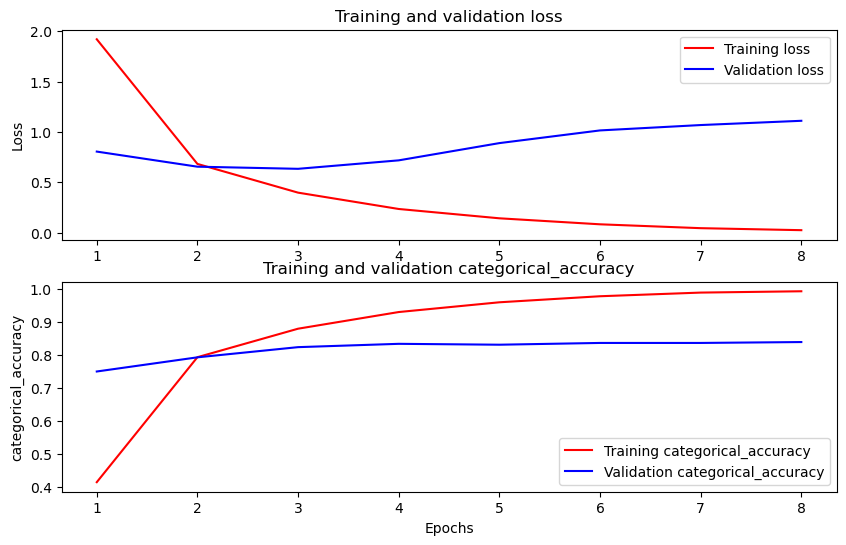

In [15]:
history_dict = history.history
print(history_dict.keys())

metrics_name=[m.name for m in metrics]

fig = plt.figure(figsize=(10, 3*(len(metrics_name)+1)))
fig.tight_layout()
epochs = range(1, config.EPOCHS + 1)

plt.subplot(len(metrics_name)+1, 1, 1)
# r is for "solid red line"
plt.plot(epochs, history_dict['loss'], 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for i in range(0,len(metrics_name)):

    plt.subplot(len(metrics_name)+1, 1, i+2)
    plt.plot(epochs, history_dict[metrics_name[i]], 'r', label='Training {}'.format(metrics_name[i]))
    plt.plot(epochs, history_dict['val_{}'.format(metrics_name[i])], 'b', label='Validation {}'.format(metrics_name[i]))
    plt.title('Training and validation {}'.format(metrics_name[i]))
    plt.ylabel(metrics_name[i])
    plt.legend(loc='lower right')
    
plt.xlabel('Epochs')
plt.show()
plt.savefig('results/img/RE/{}_history.png'.format(model_name))
plt.close()

170/170 [==============================] - 60s 350ms/step


<AxesSubplot:>

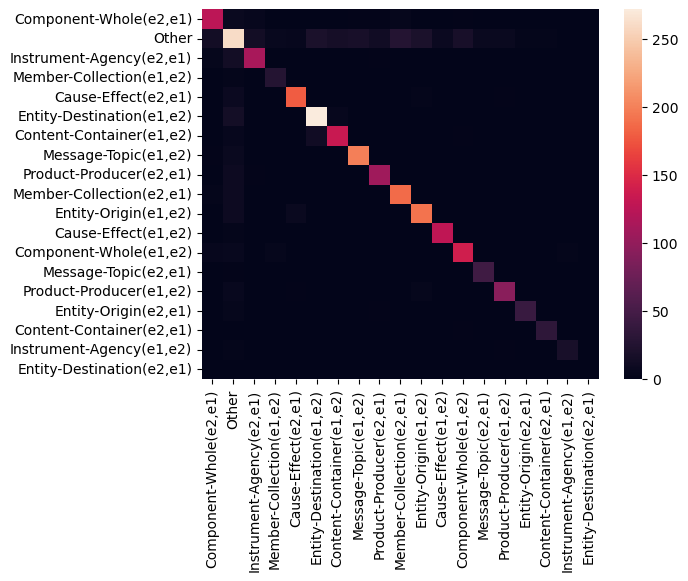

In [16]:
tss_time= time.process_time()
y_pred=model.predict(test_ds['X'],batch_size=CONFIG.BATCH_SIZE).argmax(axis=1)
tse_time= time.process_time()
test_time=tse_time-tss_time
y_true=test_ds['Y']
test_result=evaluation(y_true,y_pred)
test_result.setdefault('History',history.history)
test_result.setdefault('Time_cost',{'train':train_time,'test':test_time})
#matrix=tf.math.confusion_matrix(y_true,y_pred).numpy()
sbn.heatmap(test_result['confusion_matrix'],xticklabels=invdict,yticklabels=invdict,annot=False)

In [17]:
print('accuracy: '+str(test_result['accuracy']))
print('macro: '+str(test_result['Macro']))
print('micro: '+str(test_result['Micro']))
print('weighted: '+str(test_result['Weighted']))

accuracy: 0.8446816341553184
macro: {'precision': 0.8521929296469384, 'recall': 0.8175375642324051, 'f1': 0.807657862821063}
micro: {'precision': 0.8446816341553184, 'recall': 0.8446816341553184, 'f1': 0.8446816341553184}
weighted: {'precision': 0.8401417901214384, 'recall': 0.8446816341553184, 'f1': 0.8406811307753589}


In [18]:
with open('results/quick_result.json','r',encoding='UTF-8')as f:
    s=json.load(f)
s.setdefault(model_name,test_result)
s[model_name]=test_result
with open('results/quick_result.json','w',encoding='UTF-8')as f:
    json.dump(s,f,indent=2)

In [19]:
test_result.setdefault('Original',{'y_true':y_true,'y_pred':[int(x) for x in y_pred]})
metadata={'model_type':config.ENCODER_TYPE,
          'task_type':config.TASK,
          'epochs':config.EPOCHS,
          'learning_rate':config.LEARNING_RATE,
          'batch_size':config.BATCH_SIZE,
          'max_length':config.MAX_LENGTH,
          'model_name':model_name,
          'optimizer':optimizer._name,
          'metrics':[m.name for m in metrics],
          'loss':loss.name,
          'class_name':invdict,
          'is_saved':config.SAVE_MODEL,
          'devices':[gpu.name for gpu in GPUtil.getAvailable()],
          #'structure':model.summary(),
          'preprocess_method':config.PREPROCESS_METHOD,
          }

In [20]:
if config.SAVE_MODEL:
    model.save('models/{}'.format(model_name))
saved_data={'Metadata':metadata,
            'Result':test_result}
with open('results/NRE_test_result.json','r',encoding='UTF-8')as f:
    s=json.load(f)
s.setdefault('task',config.TASK)
s.setdefault('Results',[])
s['Results'].append(saved_data)
with open('results/NRE_test_result.json','w',encoding='UTF-8')as f:
    json.dump(s,f,indent=2)

INFO:tensorflow:Assets written to: models/roberta-base-None_EP8_BS16_LR3e-05_ML128\assets


INFO:tensorflow:Assets written to: models/roberta-base-None_EP8_BS16_LR3e-05_ML128\assets
